# **03_DataExploration**

## Objectives

* To conduct exploratory data analysis (EDA) to understand which factors are associated with XX to meet business requirement one (Client is interested in determining which demographic, lifestyle, medical and symptom factors are associated with clinical measures of disease, in terms of FEV1 and FVC)

## Inputs

* Raw data generated from "01_DataCollection". Saved as: inputs\datasets\raw\asthma_disease_data.csv

## Outputs

* Generate code that answers business requirement one, and can be used to build the Streamlit App

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/AsthmaBurden/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/AsthmaBurden'

# Load Data

Load the data and drop "DoctorInCharge" as not needed for analyses.

In [4]:
import pandas as pd

df_raw_path = "outputs/datasets/cleaned/asthma_disease_data_cleaned.csv"
df = pd.read_csv(df_raw_path)
df.head(5)


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63.0,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,...,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26.0,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,...,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57.0,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,...,0,1.698011,5.022553,1,1,1,0,1,1,0
3,40.0,1,2,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,...,0,3.032037,2.300159,1,0,1,1,1,0,0
4,61.0,0,0,3,19.283802,0,4.604493,3.127048,9.625799,0.980875,...,0,3.470589,3.067944,1,1,1,0,0,1,0


---

# Data Exploration
---

Business requirement one focues on identifying the relationships between features and with the target variable (asthma status). 

Exploratory data analyses was performed for each feature, by asthma status. Additional exploratory analyses was performed to look at asthma patients by severity (defined by LungFunctionFEV1 and LungFunctionFVC), to assess feasibility of understanding asthma prognosis.



## Understanding the features and target (additional exploratory data analysis)
---

To assess feasibility of understanding severity of asthma patients, exploratory analyses was performed. Majority of the features in the dataset were not disease specific. Clinical factors, such as LungFunctionFEV1 and LungFunctionFVC were the most specific to asthma patients due to the underlying pathophysiology. For this reason, a "LowLungFunction" feature was created, based on "severe" ranges for FEV1 and FVC. 

In [5]:
# Create a copy of the dataframe for exploration of low lung function
df_lung_function = df.copy()

# Define threshold for low lung function (e.g., ≤ 1.5 L)
threshold = 1.5

# Create binary variable: 1 = low lung function, 0 = normal
df_lung_function['LowLungFunction'] = ((df_lung_function['LungFunctionFEV1'] <= threshold) |
                                (df_lung_function['LungFunctionFVC'] <= threshold)).astype(int)

print(df_lung_function[['LungFunctionFEV1', 'LungFunctionFVC', 'LowLungFunction']].head())
print("-"*30)

counts = df_lung_function['LowLungFunction'].value_counts()
print(counts)

   LungFunctionFEV1  LungFunctionFVC  LowLungFunction
0          1.369051         4.941206                1
1          2.197767         1.702393                0
2          1.698011         5.022553                0
3          3.032037         2.300159                0
4          3.470589         3.067944                0
------------------------------
LowLungFunction
0    2026
1     366
Name: count, dtype: int64


New feature was crosstabulated by asthma status:

In [6]:
# Crosstab: LowLungFunction vs Diagnosis
counts_by_asthma = pd.crosstab(df_lung_function['LowLungFunction'], df_lung_function['Diagnosis'])

print(counts_by_asthma)
print("-"*30)

Diagnosis           0    1
LowLungFunction           
0                1914  112
1                 354   12
------------------------------


Check whether low lung function is associated with asthma diagnosis:

In [9]:
from scipy.stats import chi2_contingency

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(counts_by_asthma)

print(f"Chi-square statistic: {chi2:.3f}")
print(f"P-value (Chi-square test): {p_value:.4f}")


Chi-square statistic: 2.750
P-value (Chi-square test): 0.0973


Low lung function was defined based on available criteria in the dataset; although a more clinical measure related to asthma, FEV1 and FVC percent predicted are more accurate, utilised measures in the real-world. Additionally, there was no significant association between low lung function and diagnosis, with a small pool for analysis (only n=12 asthma patients with low lung function). For this reason, further analysis regarding prediction of severe asthma and prognosis will not be performed. 

### Descriptive statistics for continuous features (Age, BMI, PhysicalActivity, DietQuality, SleepQuality, DustExposure, PollutionExposure, PollenExposure, LungFunctionFEV1 and LungFunctionFVC)
---

Loop over continuous features (float) and show a violin plot (amended from box plot to show distribution). No clear tails on violon plots for continuous features.

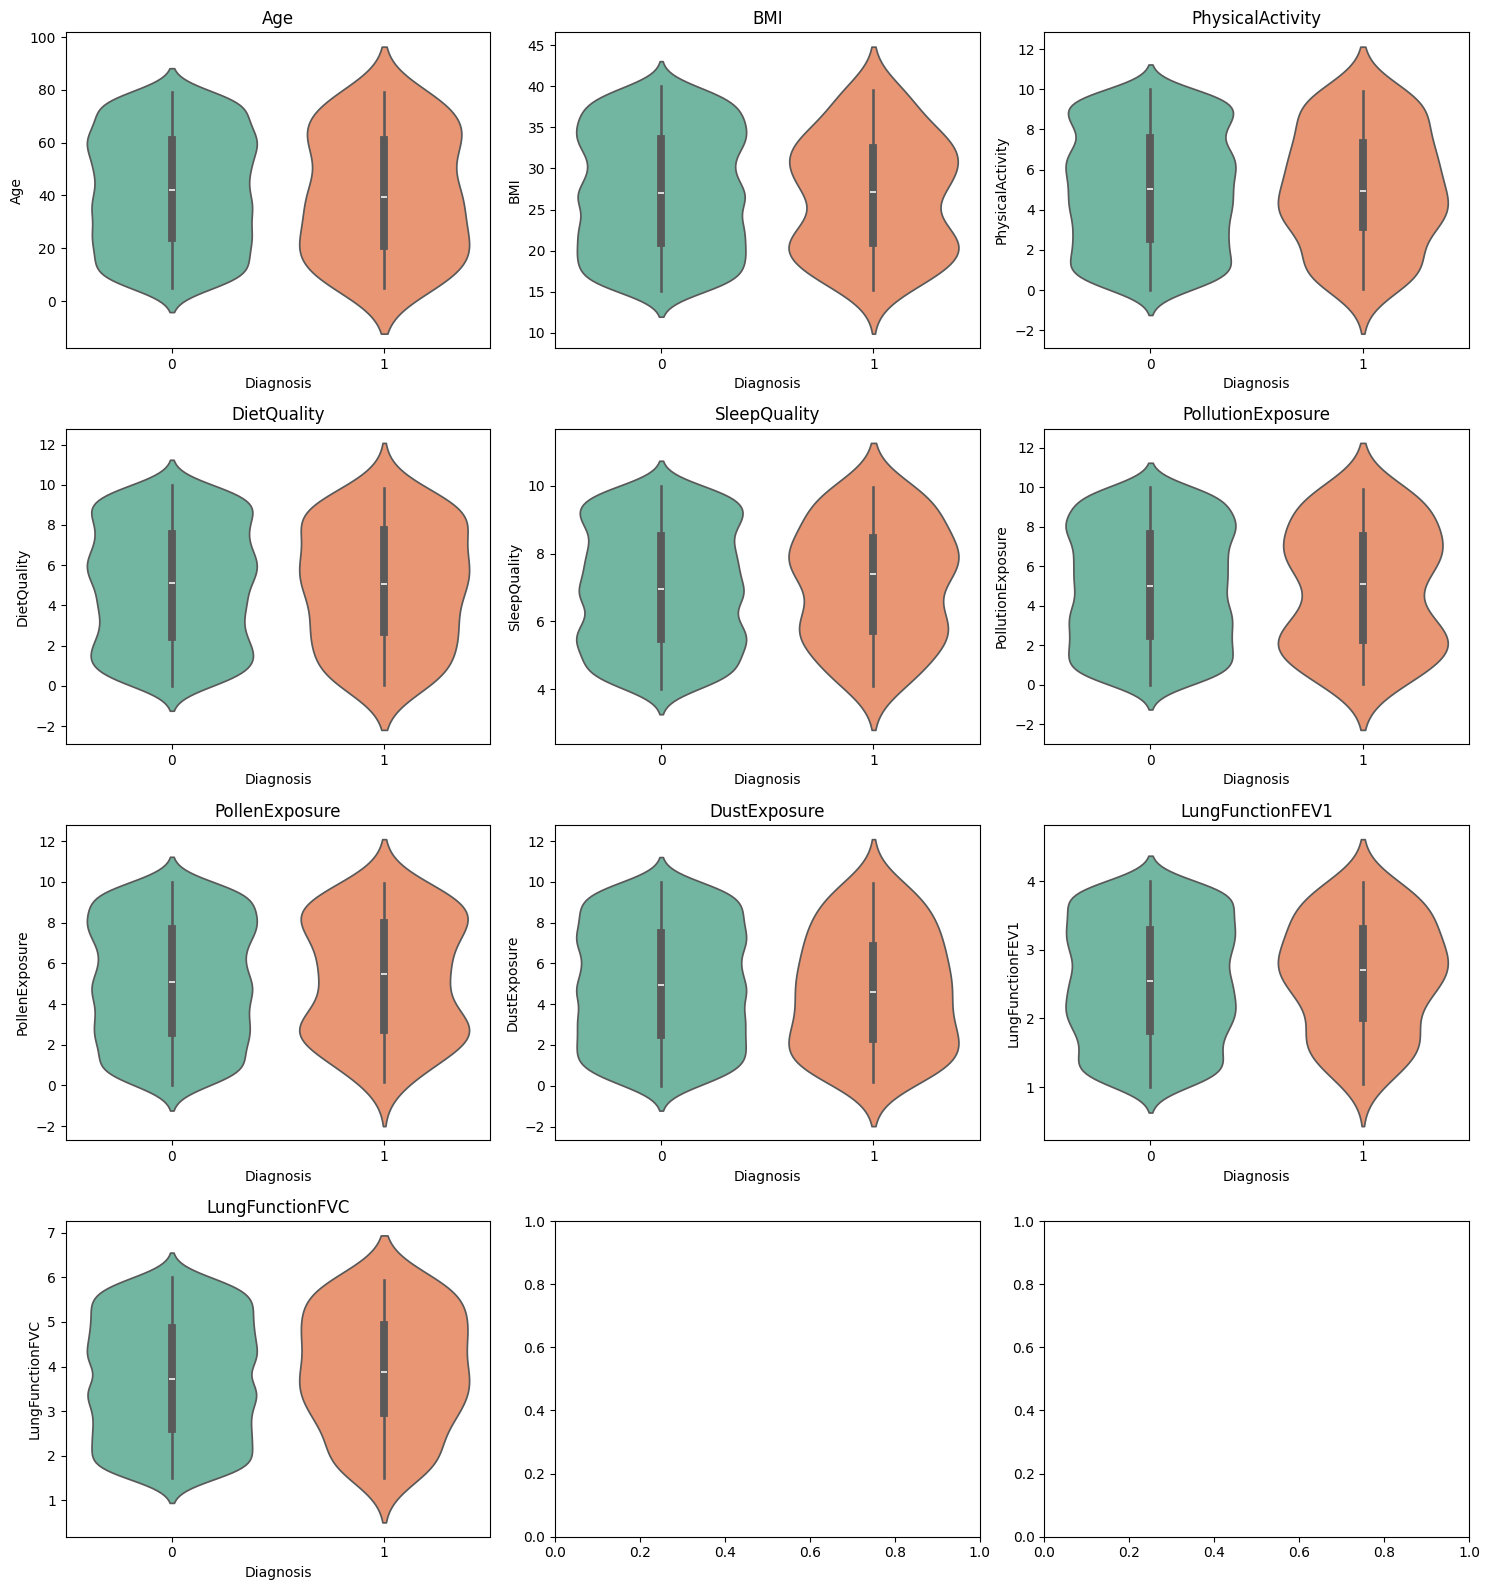

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

continuous_features = df.select_dtypes(include='float').columns.tolist()

fig, axes = plt.subplots(4, 3, figsize=(15, 16))
axes = axes.flatten()

for ax, feature in zip(axes, continuous_features):
    sns.violinplot(x='Diagnosis', y=feature, data=df, hue='Diagnosis', ax=ax, inner='box', palette='Set2', legend=False)
    ax.set_title(feature)

plt.tight_layout()
plt.show()


### Descriptive statistics for binary (integer) features (Smoking, FamilyHistoryAsthma, PetAllergy, HistoryOfAllergies etc):
---
As the target and a subset of features are binary (0: No, 1: Yes), contingency tables were generated.

In [8]:
target = 'Diagnosis'
binary_features = df.select_dtypes(include='int').columns.drop(target)

encoding_maps = {
    # Binary (0/1)
    "Gender": {0: "Male", 1: "Female"},
    "Smoking": {0: "No", 1: "Yes"},
    "PetAllergy": {0: "No", 1: "Yes"},
    "FamilyHistoryAsthma": {0: "No", 1: "Yes"},
    "HistoryOfAllergies": {0: "No", 1: "Yes"},
    "Eczema": {0: "No", 1: "Yes"},
    "HayFever": {0: "No", 1: "Yes"},
    "GastroesophagealReflux": {0: "No", 1: "Yes"},
    "Wheezing": {0: "No", 1: "Yes"},
    "ShortnessOfBreath": {0: "No", 1: "Yes"},
    "ChestTightness": {0: "No", 1: "Yes"},
    "Coughing": {0: "No", 1: "Yes"},
    "NighttimeSymptoms": {0: "No", 1: "Yes"},
    "ExerciseInduced": {0: "No", 1: "Yes"},
    "Diagnosis": {0: "No", 1: "Asthma"},

    # Multi-class categorical
    "Ethnicity": {
        0: "Caucasian",
        1: "African American",
        2: "Asian",
        3: "Other"
    },
    "EducationLevel": {
        0: "None",
        1: "High School",
        2: "Bachelor's",
        3: "Higher"
    }
}

contingency_tables = {}

# Loop over features and create contingency tables
for feature in binary_features:
    # Map encoding
    target_labels = df[target].map(encoding_maps.get(target, {}))
    feature_labels = df[feature].map(encoding_maps.get(feature, {}))

    # Contigency table targets
    contingency = pd.crosstab(target_labels, feature_labels)
    contingency_tables[feature] = contingency

    print(f"Contingency table: {target} vs {feature}")
    print(contingency)
    print("-"*30)

Contingency table: Diagnosis vs Gender
Gender     Female  Male
Diagnosis              
Asthma         62    62
No           1118  1150
------------------------------
Contingency table: Diagnosis vs Ethnicity
Ethnicity  African American  Asian  Caucasian  Other
Diagnosis                                           
Asthma                   25     11         73     15
No                      450    218       1392    208
------------------------------
Contingency table: Diagnosis vs EducationLevel
EducationLevel  Bachelor's  High School  Higher  None
Diagnosis                                            
Asthma                  29           51      19    25
No                     720          882     213   453
------------------------------
Contingency table: Diagnosis vs Smoking
Smoking      No  Yes
Diagnosis           
Asthma      110   14
No         1943  325
------------------------------
Contingency table: Diagnosis vs PetAllergy
PetAllergy    No  Yes
Diagnosis            
Asthma       

Contingency table: Diagnosis vs FamilyHistoryAsthma
FamilyHistoryAsthma    No  Yes
Diagnosis                     
Asthma                 87   37
No                   1585  683
------------------------------
Contingency table: Diagnosis vs HistoryOfAllergies
HistoryOfAllergies    No  Yes
Diagnosis                    
Asthma                75   49
No                  1362  906
------------------------------
Contingency table: Diagnosis vs Eczema
Eczema       No  Yes
Diagnosis           
Asthma      102   22
No         1831  437
------------------------------
Contingency table: Diagnosis vs HayFever
HayFever     No  Yes
Diagnosis           
Asthma       97   27
No         1689  579
------------------------------
Contingency table: Diagnosis vs GastroesophagealReflux
GastroesophagealReflux    No  Yes
Diagnosis                        
Asthma                   100   24
No                      1914  354
------------------------------
Contingency table: Diagnosis vs Wheezing
Wheezing    No   Y

Bar charts to show the proportions amongst asthma and non-asthma patients:

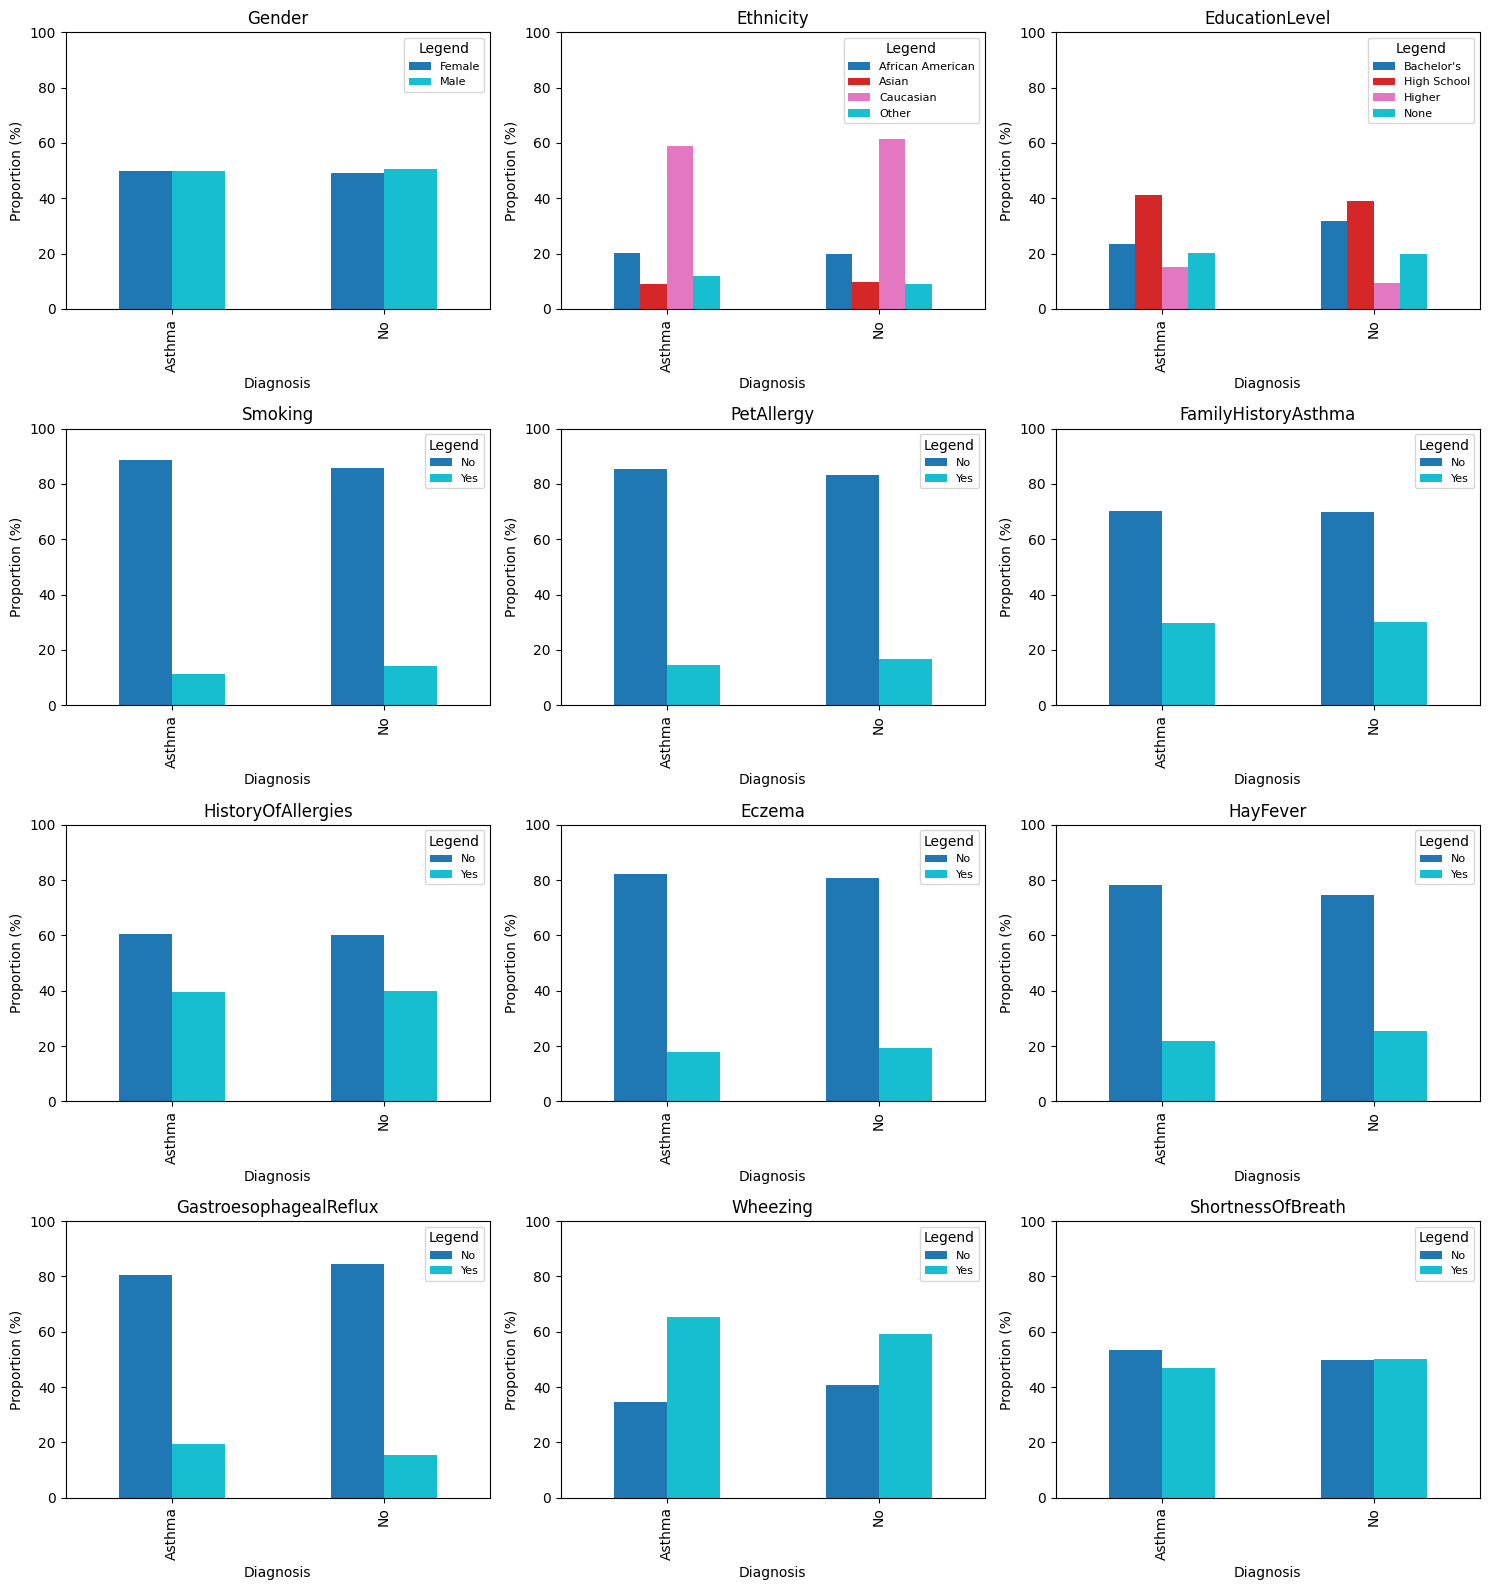

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
axes = axes.flatten()

for ax, (feature, table) in zip(axes, contingency_tables.items()):
    # Map the encoding 
    if feature in encoding_maps:
        table = table.rename(columns=encoding_maps[feature])

    # Convert counts to proportions
    proportion_table = table.div(table.sum(axis=1), axis=0) * 100
    
    # Plot grouped bar chart
    proportion_table.plot(kind='bar', stacked=False, ax=ax, colormap='tab10', legend=True)
    ax.set_title(feature)

    ax.set_ylabel('Proportion (%)')
    ax.set_ylim(0, 100)
    ax.legend(title='Legend', fontsize=8)

plt.tight_layout()
plt.show()

Ethnicity and education level have more than two categories. To be combined to maximise base size for analyses:

In [9]:
# Create a copy of the dataframe
df_updated = df.copy()

# Replace Ethnicity values
df_updated['Ethnicity'] = df_updated['Ethnicity'].replace({
    0: 0,  # keep White as 0
    1: 1,  # African American → 1
    2: 1,  # Asian → 1
    3: 1   # Other → 1
})

# Replace EducationLevel values
df_updated['EducationLevel'] = df_updated['EducationLevel'].replace({
    1: 1,  # Bachelor/Higher → 1
    2: 1,  # Bachelor/Higher → 1
    3: 0   # None/High school → 0
})

# Updated encoding maps 
encoding_maps_updated = encoding_maps.copy()  # start from original

# Ethnicity: 0 = White, 1 = Others (collapsed African American, Asian, Other)
encoding_maps_updated['Ethnicity'] = {
    0: "White",
    1: "Other"
}

# EducationLevel: 0 = None/High school, 1 = Bachelor/Higher
encoding_maps_updated['EducationLevel'] = {
    0: "None/High School",
    1: "Bachelor/Higher"
}

df_updated.head(5)

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63.0,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,...,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26.0,1,1,1,22.757042,0,5.897329,6.341014,5.153966,1.969838,...,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57.0,0,1,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,...,0,1.698011,5.022553,1,1,1,0,1,1,0
3,40.0,1,1,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,...,0,3.032037,2.300159,1,0,1,1,1,0,0
4,61.0,0,0,0,19.283802,0,4.604493,3.127048,9.625799,0.980875,...,0,3.470589,3.067944,1,1,1,0,0,1,0


In [10]:
new_contingency = {}

for col in ['Ethnicity', 'EducationLevel']:
    table = pd.crosstab(target_labels, df_updated[col])
    new_contingency[col] = table  # store in dict
    print(f"Contingency table: Diagnosis vs {col}")
    print(table)
    print("-"*30)

Contingency table: Diagnosis vs Ethnicity
Ethnicity     0    1
Diagnosis           
Asthma       73   51
No         1392  876
------------------------------
Contingency table: Diagnosis vs EducationLevel
EducationLevel    0     1
Diagnosis                
Asthma           44    80
No              666  1602
------------------------------


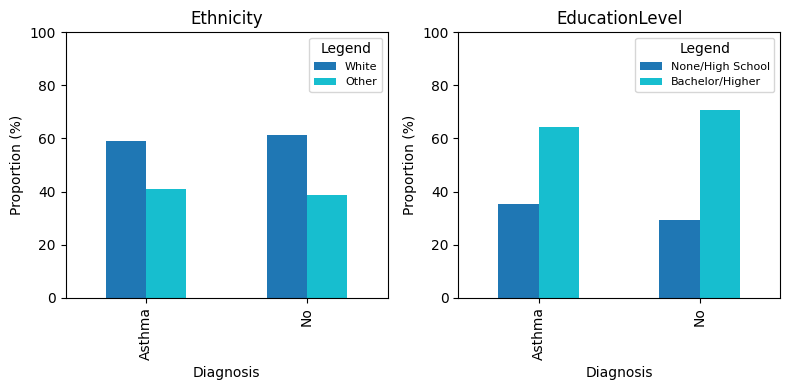

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()

for ax, (feature, table) in zip(axes, new_contingency.items()):
    # Map the updated encoding 
    if feature in encoding_maps_updated:
        table = table.rename(columns=encoding_maps_updated[feature])

    # Convert counts to proportions
    proportion_table = table.div(table.sum(axis=1), axis=0) * 100
    
    # Plot grouped bar chart
    proportion_table.plot(kind='bar', stacked=False, ax=ax, colormap='tab10', legend=True)
    ax.set_title(feature)

    ax.set_ylabel('Proportion (%)')
    ax.set_ylim(0, 100)
    ax.legend(title='Legend', fontsize=8)

plt.tight_layout()
plt.show()

### Statistical Analyses
---

### Continous features
Association between continuous features and asthma diagnosis was testing using bivariate analyses, t-test or Mann-Whitney, based on normality.


In [12]:
from scipy.stats import mannwhitneyu, ttest_ind, shapiro

continuous_features = df_updated.select_dtypes(include='float').columns.tolist()

# Create an empty dictionary for the results
continuous_results = {}

# Loop through features, ignore NaN data, and add significance finding
for feature in continuous_features:
    group0 = df_updated[df_updated['Diagnosis'] == 0][feature].dropna()
    group1 = df_updated[df_updated['Diagnosis'] == 1][feature].dropna()
    
    # Check normality
    _, p0 = shapiro(group0) if len(group0) >= 3 else (None, 0)  # Shapiro requires ≥3 samples
    _, p1 = shapiro(group1) if len(group1) >= 3 else (None, 0)
    
    # Choose t-test if normal distribution, else Mann-Whitney 
    if p0 > 0.05 and p1 > 0.05:
        stat, p = ttest_ind(group0, group1, equal_var=False)  # Welch's t-test
        test_name = "t-test"
    else:
        stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
        test_name = "Mann-Whitney U"
    
    significance = "Significant" if p < 0.05 else "Not significant"
    
    # Overview of the output
    continuous_results[feature] = {
        "test": test_name,
        "statistic": stat,
        "p-value": p,
        "significance": significance
    }

# Create a dataframe
continuous_results_df = pd.DataFrame(continuous_results).T
continuous_results_df


,test,statistic,p-value,significance
Age,Mann-Whitney U,146059.0,0.467335,Not significant
BMI,Mann-Whitney U,145235.0,0.53742,Not significant
PhysicalActivity,Mann-Whitney U,138709.0,0.799048,Not significant
DietQuality,Mann-Whitney U,141866.0,0.867489,Not significant
SleepQuality,Mann-Whitney U,133797.0,0.362564,Not significant
PollutionExposure,Mann-Whitney U,142477.0,0.803796,Not significant
PollenExposure,Mann-Whitney U,135082.0,0.459967,Not significant
DustExposure,Mann-Whitney U,150209.0,0.200225,Not significant
LungFunctionFEV1,Mann-Whitney U,132190.0,0.260556,Not significant
LungFunctionFVC,Mann-Whitney U,129757.0,0.147069,Not significant


Findings:
* All continuous features were not normally distributed, meaning Mann-Whitney was performed.
* The asthma and non‑asthma groups look statistically similar; no variable was statistically significant. 


### Binary features
Association between binary features and asthma diagnosis:

In [13]:
from scipy.stats import chi2_contingency, fisher_exact

# Remove diagnosis for analysis
binary_features = [col for col in df_updated.select_dtypes('int').columns if col != 'Diagnosis']

# Create an empty dictionary for the results
binary_results = {}

# Loop through features, recreate contigency tables, and add significance finding
for feature in binary_features:
    table = pd.crosstab(df_updated[feature], df_updated['Diagnosis'])

    # Run chi-square test
    chi2, p_chi, dof, expected = chi2_contingency(table)
    
    # Decide whether to use Fisher (if any expected count < 5)
    if (expected < 5).any():
        oddsratio, p_value = fisher_exact(table)
        test_used = "Fisher's exact"
    else:
        p_value = p_chi
        oddsratio = (table.iloc[1,1] / table.iloc[1,0]) / (table.iloc[0,1] / table.iloc[0,0])
        test_used = "Chi-square"
    
    # Significance
    significance = "Significant" if p_value < 0.05 else "Not significant"

    # Overview of the output
    binary_results[feature] = {
        "test": test_used,
        "p-value": p_value,
        "odds_ratio": oddsratio,
        "significance": significance
    }

# Create a dataframe
binary_results_df = pd.DataFrame(binary_results).T
binary_results_df

,test,p-value,odds_ratio,significance
Gender,Chi-square,0.951543,1.028623,Not significant
Ethnicity,Chi-square,0.643505,1.110152,Not significant
EducationLevel,Chi-square,0.176599,0.755873,Not significant
Smoking,Chi-square,0.416359,0.760895,Not significant
PetAllergy,Chi-square,0.606093,0.846368,Not significant
FamilyHistoryAsthma,Chi-square,1.0,0.986941,Not significant
HistoryOfAllergies,Chi-square,0.998995,0.982163,Not significant
Eczema,Chi-square,0.761792,0.903711,Not significant
HayFever,Chi-square,0.40648,0.811976,Not significant
GastroesophagealReflux,Chi-square,0.323529,1.297627,Not significant


Most binary features showed no significant association with asthma status. The exception was ExcerciseInduced, which showed a statistically significant association, with an odds ratio of 1.7. This indicates that exercise induced symptoms were 1.7 times more likely to be reported by patients with asthma. Exercise induced asthma is a known disease subtype, and may be reflected here.

---

## Power Predictive Score
---

Heatmap with Power Predictive Score (PPS) 
* PPS detects both linear and non-linear relationships between two variables and helps assess predictive relationships and potential multicollinearity. Scores range from 0 (no predictive power) to 1 (perfect predictive power). However, as the base for asthma is low, PPS remains low (limitation of a highly imbalanced dataset)

In [ ]:
import ppscore as pps

pps_matrix = pps.matrix(df) #ERRROR

heatmap_data = pps_matrix.pivot(
    index="x",
    columns="y",
    values="ppscore"
).round(2)

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="inferno"
)
plt.title("PPS Heatmap (Predicting Asthma Status)")
plt.show()

NameError: name 'df' is not defined

---

# Push files to repo

Save the updated dataframe:

In [15]:
import os
try:
    os.makedirs('outputs/datasets/cleaned', exist_ok=True)  
except Exception as e:
    print(e)

df.to_csv("outputs/datasets/cleaned/asthma_disease_data_amended.csv", index=False)

# Train and Test Set
---

Split the database, based on code from the "churnometer" walkthough example:

In [16]:
df_updated.head(10)


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63.0,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,...,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26.0,1,1,1,22.757042,0,5.897329,6.341014,5.153966,1.969838,...,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57.0,0,1,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,...,0,1.698011,5.022553,1,1,1,0,1,1,0
3,40.0,1,1,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,...,0,3.032037,2.300159,1,0,1,1,1,0,0
4,61.0,0,0,0,19.283802,0,4.604493,3.127048,9.625799,0.980875,...,0,3.470589,3.067944,1,1,1,0,0,1,0
5,21.0,0,1,0,21.812975,0,0.470044,1.759118,9.549262,1.711446,...,0,2.328191,5.898515,1,0,1,0,0,1,0
6,45.0,1,1,1,30.245954,1,9.371784,7.030507,5.746128,7.664306,...,0,2.995100,1.701512,1,1,1,0,0,0,0
7,26.0,0,0,1,26.048416,1,8.344096,1.626484,6.431179,6.939046,...,0,2.069343,4.012260,1,0,0,1,1,1,0
8,49.0,1,1,1,32.676204,0,2.690256,3.920034,5.843645,3.180421,...,1,1.761242,5.190931,1,1,1,1,0,0,0
9,45.0,1,1,1,29.910298,0,2.895720,2.607700,7.234908,1.711722,...,0,2.848420,5.771022,1,0,0,0,1,1,0


In [17]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet, _, __ = train_test_split(
                                        df_updated,
                                        df_updated['Diagnosis'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1913, 27) 
TestSet shape: (479, 27)


Push the train and test dataset:

In [18]:
import os

os.makedirs("outputs/datasets/cleaned", exist_ok=True)

# Train set
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

# Test set
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)

# Conclusion and Next Steps
---

To answer Business Question One, initial bivariate analyses was performed to understand the distribution of data and the relationships between the target (Diagnosis) and features.

Continuous features were visualized using violin plots to understand distribution. In this dataset, most features showed overlapping violin shapes with no clear tails.  Shapiro-Wilk test was used to test the distrubiton of continuous features; as all features passed the distrubution test, non-parametric (Mann-Whitney) test was performed. No continuous features were significantly associated with asthma status (Diagnosis).

Additionally, contigency tables were generated for binary features, alongside bar charts. Due to the low bases for specific subgroups, groups were combined to maximize bases for EducationLevel and Ethnicity (two categories for both). Chi-square test wad performed for all features; ExerciseInduced was significantly associated with asthma status (Diagnosis).

Train and test sets were generated for feature engineering and modeling. 

Next steps:
* Prepare data for feature engineering and modeling, to answer Business Requirement Two.